# A deep-learning neural network for image recognition
We present here a `Python Keras` implementation of a deep learning neural network for image recognition.
The publicly available `MNIST` dataset is used.

`Keras` is a popular `Python` library for deep learning models:
- wrapper for `TensorFlow`
- minimalistic
- modular
- easy to implement

The `MNIST` database (Modified National Institute of Standards and Technology database) is a large database of hand-written digits (details and data [here](http://yann.lecun.com/exdb/mnist/)):

![mnist](https://drive.google.com/uc?id=1KNK3-8qahQixvL-StpDAs6GoOUAHKSDy)

Deep learning consists of neural networks with multiple hidden layers that learn increasingly abstract and complex representations of the input data.
For instance, if we train a deep learning model to recognize hand-written digits (images):

- the first hidden layers might only learn local edge patterns;
- subsequent layers learns more complex representations of the data;
- the last layer will classify the image as one of ten digits.

For image recognition we use a specific deep learning architecture: **convolutional neural networks** (*CNN*), which assume that input data are images, thereby greatly reducing the number of model parameters to be tuned (more on *CNN's* later in the course).


## Importing libraries

We import the necessary libraries to build a DL NN for image recognition:

- import the Sequential model type from Keras: linear stack of neural network layers, to be used to build a feed-forward CNN
-  import the 'core' layers from Keras: layers that are used in almost any neural network
- import the CNN layers from Keras: convolutional layers to train the model on image data
- load the MNIST dataset

In [1]:
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K # needed for image_data_format()
from keras.datasets import mnist

#Configuration parameters

Define model parameters:

- batch size: DL models typically do not process the entire dataset at once, rather break it in **batches**
- n. of classes: n. of classes to predict (10 digits, in the MNIST problem)
- n. of epochs: n. of **iterations** over the entire dataset

In [2]:
batch_size = 128 # n. of samples/records in each batch
num_classes = 10 # ten digits -> ten classes
epochs = 12

# input image dimensions (pixels)
img_rows, img_cols = 28, 28

# Input data

We load the data from the MNIST dataset, and assign them to the training and testing sets. 

Image data is generally harder to work with than flat relational data. The MNIST dataset is a beginner-friendly intoduction to working with image data: it contains $70\,000$ labeled images of handwritten digits. These are grey-scale images, 28 x 28 pixels.

The MNIST dataset comprises $60\,000$ training observations and $10\,000$ test observations: the function `load_data()` automatically assigns these to the training and testing sets.

In [3]:
# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Size of the training set")
print(X_train.shape)
print("Size of the test set")
print(X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Size of the training set
(60000, 28, 28)
Size of the test set
(10000, 28, 28)


Data have been split into a **training** and a **testing set**, and within these into a **three-dimensional array** $X$ of **features** (samples x pixels x pixels) and a vector $y$ of labels (0-9 digits).

Each record in the 3-D array $X$ is a 28 x 28 matrix of grayscale intensities (1 byte = 8 bits = 0 - 255 values). Grayscale (black-n-white) images only use one color channel. Colour images use three channels (e.g. RGB) and each image (record) is therefore a 3-D matrix (pixels x pixels x 3).

First training label:  5


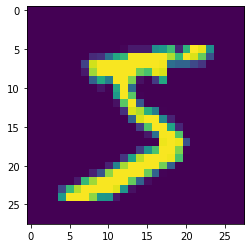

In [ ]:
print("First training label: ",y_train[0])

from matplotlib import pyplot as plt
plt.imshow(X_train[0])

By default the matplotlib function `imshow()` uses pseudocolors to plot grayscale images; if you want to display the actual grayscale image, you can specify the color mapping parameters:

First training label:  5


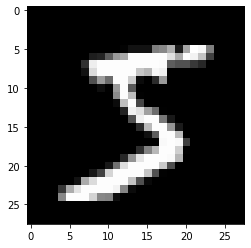

In [ ]:
print("First training label: ",y_train[0])
plt.imshow(X_train[0], cmap='gray', vmin=0, vmax=255)

# Data preprocessing

First, we need to explicitly declare the depth of the image representation array: in the case of grayscale images there is only one channel, and this dimension is 1.

We use the utility function [image_data_format()](https://keras.io/api/utils/backend_utils#imagedataformat-function) from keras [backend utilities](https://keras.io/api/utils/backend_utils/) to discover the convention ('channels_first' or 'channels_last') of our current system.

Depending on the backend (Theano or TensorFlow), the depth dimension is either the first or the last to be declared:

In [5]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("Modified array dimensions:")
print(X_train.shape) 
print(input_shape)  


Modified array dimensions:
(60000, 28, 28, 1)
(28, 28, 1)


We then convert the input data type to `float32` and normalize the data values to the range $[0, 1]$.
These are operational modifications necessary to speed up and optimize the calculations.

Finally, label vectors are converted to binary class matrices. This serves to convert a vector of numerical digits to a matrix of ten classes per observation, which is a better suited representation for a classification problem.

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 #max value of pixel intensity
X_test /= 255 #max value of pixel intensity
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices (also known as OHE - One Hot Encoding)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
print(y_train[0:4]) ## print first four training examples (labels): which digits are these?

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


 # Model building

We now define our deep-learning **neural network architecture**, and start building our model for image recognition.

First, we declare a [sequential model](https://keras.io/guides/sequential_model/), that is a sequence of layers each with one input tensor and one output tensor. 
Then we add a first convolutional layer ([Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)) to our model; parameters are:

- number of convolution filters (n. of kernels to convolve with the input data)
- number of rows and columns in each convolution kernel
- type of activation function
- shape of the input array


In [ ]:
model = Sequential()
model.add(
          Conv2D(32, kernel_size=(3, 3),
          activation='relu',
          input_shape=input_shape))

print(model.output_shape) ## convolutional "padding" (28-2 x 28-2) + 32 kernels

(None, 26, 26, 32)


The input shape is (60000, 28, 28, 1): 28 x 28 pixels, times 1 channel (grayscale), per 60,000 training samples.
The convolutional output shape is:

- None: not yet any samples trained (to be added later)
- 26 x 26: convolutional padding (3x3 kernel size $\rightarrow$ 28-2 x 28-2)
- 32: n. of convolutional filters (kernels)

Then we can add more layers to the deep-learning model:

- the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) layer is a way to regularize our model to prevent overfitting
- [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) is a way to reduce the number of model parameters by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values
- a [Dense](https://keras.io/api/layers/core_layers/dense/) layer whose first parameter is the output size of the layer (weights from the Convolution layers must be flattened -made 1-dimensional- before being passed on to the fully connected Dense layer)
- the final layer has an output size of 10 (the 10 classes of digits): the activation function here is [softmax](https://keras.io/api/layers/activations/#softmax-function) (the multiclass analog of the logistic function) which returns a probability for each class, e.g. 10% of chance of the sample belonging to class 1, 15% for class 2 and so forth. The sum of all probabilities adds to 100%

In [ ]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

### Compiling the model
When compiling the model we specify the **loss function** (here: [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)) and the **optimizer** (here: [Adadelta](https://keras.io/api/optimizers/adadelta/))

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Training the deep-learning model

We then fit the model on the training data, specifying:

- the batch size
- the number of epochs to train the model

In [ ]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/12
469/469 [==============================] - 6s 14ms/step - loss: 2.2681 - accuracy: 0.1697
Epoch 2/12
469/469 [==============================] - 6s 13ms/step - loss: 2.1905 - accuracy: 0.2946
Epoch 3/12
469/469 [==============================] - 6s 13ms/step - loss: 2.0861 - accuracy: 0.4054
Epoch 4/12
469/469 [==============================] - 6s 13ms/step - loss: 1.9511 - accuracy: 0.4871
Epoch 5/12
469/469 [==============================] - 6s 13ms/step - loss: 1.7834 - accuracy: 0.5530
Epoch 6/12
469/469 [==============================] - 6s 14ms/step - loss: 1.6010 - accuracy: 0.5991
Epoch 7/12
469/469 [==============================] - 7s 14ms/step - loss: 1.4271 - accuracy: 0.6317
Epoch 8/12
469/469 [==============================] - 6s 13ms/step - loss: 1.2763 - accuracy: 0.6591
Epoch 9/12
469/469 [==============================] - 6s 13ms/step - loss: 1.1550 - accuracy: 0.6791
Epoch 10/12
469/469 [==============================] - 6s 13ms/step - loss: 1.0561 - accura

# Model evaluation

We can now measure the performance (in terms of prediction accuracy) of the trained deep-learning model for image recognition. 
To measure the performance, we applied our trained model to independent test data.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6744098663330078
Test accuracy: 0.8392000198364258


# Confusion matrix

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is another way to express the accuracy of your predictions. It's a square matrix, with as many rows (and columns) as your classes. Rows represent *true values* and columns represent *predicted values*. On the main diagonal are thus reported the correct predictions, while off-diagonal elements represent errors.

We'll use the [confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function part of [scikit-learn library](https://scikit-learn.org/stable/).

In [ ]:
#asking our model to return its predictions for the test set
predictions = model.predict(X_test)

#confusion_matrix function requires actual classes labels (expressed as int)
#and not probabilities as we handled so far
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test.argmax(axis=1)

#rows are true values, columns are predicted values, numbering starts from zero
import sklearn.metrics
sklearn.metrics.confusion_matrix(true_classes, predicted_classes)

array([[ 930,    0,    1,    3,    0,    2,   26,    1,   17,    0],
       [   0, 1085,    8,   14,    0,    1,    5,    0,   22,    0],
       [  19,   10,  866,   23,   14,    0,   42,   24,   32,    2],
       [   3,   11,   29,  884,    0,   17,    6,   27,   20,   13],
       [   3,    9,    4,    0,  768,    0,   22,    1,   12,  163],
       [  24,   14,    4,  149,   30,  570,   38,    9,   45,    9],
       [  25,   14,    7,    0,    9,    9,  890,    0,    4,    0],
       [   2,   40,   28,    3,   11,    0,    0,  886,    7,   51],
       [  15,   34,   11,   78,   11,   24,   24,   23,  712,   42],
       [  19,   20,    6,   15,   88,    9,    1,   41,    9,  801]])

Can you spot the most ambiguous, often confounded classes?